# Fluxonium parameter fitting from experimental spectrum data
In the notebook, we show an efficient method to fit qubit parameters by SuperGrad. The Hamiltonian of a fluxonium is given by
$$
	H_{\mathrm{f}} = 4E_{\mathrm{C}} n^2 + \frac{1}{2} E_{\mathrm{L}} (\varphi +\varphi_{\mathrm{ext}})^2
    -E_{\mathrm{J}}\cos \left( \varphi \right),
$$
where $E_C$, $E_J$ and $E_L$ form the parameter set $\mathbf{x}=(E_C,E_J,E_L)$. 
We can try to infer these parameters through measuring energy eigenvalues with different $\varphi_{ext}$ in experiments.
For example, we can measured pairs $\{(\varphi_{\mathrm{ext},i}, e_{01,i})\}$, where $e_{01,i} = E_1(\varphi_{\mathrm{ext}})-E_0(\varphi_{\mathrm{ext}})$ is the energy difference between lowest 2 eigenvalues.
Then, we can minimize the distance between the data and the theoretically computed $f_{01}(\varphi_{\mathrm{ext}},E_C,E_J,E_L)$ by diagonalizing the above Hamiltonian.
A caveat is that we cannot directly control $\varphi_{\mathrm{ext}}$ in the experiment.
Instead, we apply a voltage $z_i$ which is roughly linear with $\varphi_{\mathrm{ext}}$.

However, it is not always obvious how to extract $e_{01,i}$ from experiment data when the signal-to-noise ratio is low.
Also, we might miss some signals if we are scanning a small part of the 2D plane.
For example, below is a fitting of data we will obtain in the end of this notebook. The left side is the data we measured. If we simply find peaks in every column, the columns without a signal will give very wrong $e_{01,i}$.

![!\[fitting_result.png\](attachment:fitting_result.png)](fitting_result.png)

Thanks to a suggestion from Lei Wang, here we test a distance based on Kullback-Leibler divergence (KL-DIV). KL-DIV is a measure of how different two probability distributions are from each other. Therefore, to use KL-DIV, we need to first convert data like above images to probability distributions $\mathbf{P}(x, \varepsilon)$ with proper normalization. For example, we can make the elements of a 2D array positive and sum to 1. And we construct the model probability distribution $\mathbf{Q}(x, \varepsilon)$ by introducing "linewidth" parameter $\lambda$, x-axis linear transformation parameters $a,b$, background noise parameter $c$,
\begin{equation}
Q(x, \varepsilon) = \frac{1}{Z}([\frac{\lambda}{(\varepsilon-f_{01}(ax+b))^2+\lambda^2}] + c),
\end{equation}
where $Z$ is the normalization factor. In our numerical codes, we will use a slightly different but equivalent formula.

The form of the KL-DIV objective function is given by
\begin{equation}
C(P, Q) = \sum_{x, \varepsilon_i} P\log (\frac{P}{Q})
\end{equation}
We can then do gradient descent using SuperGrad.

## Load experiment data and initial guess

We provide a set of loss functions in `hamiltonian.utils.loss_function` to help the user fitting qubit. Some necessary experiment data are collected by simple API in our functions. The experiment data should contain the definition of grids(`xs`, `ys`) and measured complex data `exp_Array`. In the section, we just load data from pickle. For other use, the simple wrapper `wrapper_yaqcs_data` for `yaqcs` data could be useful.

In [1]:
import pickle
import jax
import jax.numpy as jnp

from supergrad.utils.optimize import scipy_minimize
from supergrad.utils.loss_function import loss_kl_div

# load experiment data
with open('solve_iep_by_kl_div.pickle', 'rb') as f:
    data = pickle.load(f)


## Fill initial guess

The first argument is `initial guess`, which should be filled manually. One could get the `initial guess` template by `loss_function.init` method. 

In [2]:
loss_kl_div.init(jax.random.PRNGKey(0), *data)


{'~': {'bias_phi0': Array(0., dtype=float32),
  'bias_phipi': Array(0., dtype=float32),
  'bandwidth': Array(0., dtype=float32),
  'noise': Array(0., dtype=float32)},
 'fluxonium': {'ec': Array(1., dtype=float32),
  'ej': Array(1., dtype=float32),
  'el': Array(1., dtype=float32)}}

One could set initial guess depends on the understanding of physics.

In [3]:
initial_guess = {
    '~': {
        'bias_phi0': jnp.array(-0.7),
        'bias_phipi': jnp.array(0.),
        'bandwidth': jnp.array(1.),
        'noise': jnp.array(0.2)
    },
    'fluxonium': {
        'ec': jnp.array(1.5),
        'ej': jnp.array(2.),
        'el': jnp.array(0.5)
    }
}
loss_kl_div.apply(initial_guess, *data)


Array(14.00229683, dtype=float64)

In practice, we compute the gradient and Hessian matrix of the objective function $C(f_{01}^b)$ by automatic differential from JAX, and use Newton-CG optimizer to minimize the distance. After the optimization, we compare the experiment results(Left-side) and model probability distribution(Right-side).

In [4]:
res = scipy_minimize(loss_kl_div.apply,
                     initial_guess,
                     args=data,
                     hess='jax',
                     method='newton-cg',
                     logging=True)


step: 0
parameters:
{ 'fluxonium': {'ec': 1.5, 'ej': 2.0, 'el': 0.5},
  '~': {'bandwidth': 1.0, 'bias_phi0': -0.7, 'bias_phipi': 0.0, 'noise': 0.2}}
gradient:
{ 'fluxonium': { 'ec': -0.02579329575217667,
                 'ej': -0.004528178776549792,
                 'el': -0.01391904298130431},
  '~': { 'bandwidth': -0.27528908787219786,
         'bias_phi0': 0.05869861773963589,
         'bias_phipi': -0.01376587542901947,
         'noise': -0.9733324185364222}}
loss: 14.002297
step: 1
parameters:
{ 'fluxonium': { 'ec': 1.5025010305662907,
                 'ej': 2.000439071983611,
                 'el': 0.5013496511761906},
  '~': { 'bandwidth': 1.0266932318362818,
         'bias_phi0': -0.7056916742465317,
         'bias_phipi': 0.0013347993816114573,
         'noise': 0.2943785607434733}}
gradient:
{ 'fluxonium': { 'ec': -0.01929518009324948,
                 'ej': -0.016221379977442923,
                 'el': -0.025282136053107716},
  '~': { 'bandwidth': -0.12774408287264058,
     

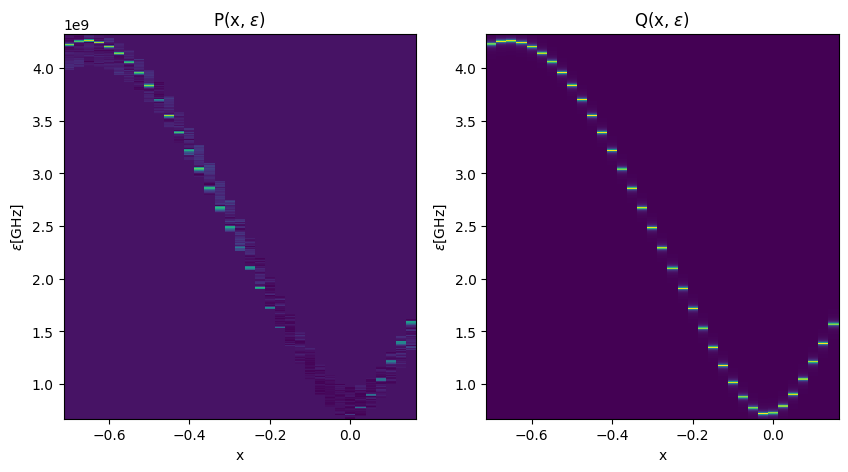

Array(13.51834523, dtype=float64)

In [5]:
loss_kl_div.apply(res.x, *(data + (True,)))
